### Load data

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

bp_df = pd.read_csv('Contextual_test_BPClass_samepatient.csv')
bg_df = pd.read_csv('Contextual_test_BGClass_samepatient.csv')
# bpbg_df = pd.read_csv('Contextual_test_BPBGClass_samepatient_4+4.csv')
bpbg_df = pd.read_csv('Contextual_test_BPBGClass_samepatient_SBP90130_A1C7.9.csv')


with open('samepatient_maskid.pkl', 'rb') as f:
    same_patient = pickle.load(f)

print(bp_df.shape)
print(bg_df.shape)
print(bpbg_df.shape)

(71180, 23)
(71180, 23)
(71180, 23)


Remove the patients with extremly large baseline BMI in BG and BPBG data!

In [61]:
bp_df = bp_df[bp_df['baseline_BMI'] < 100 ]
bg_df = bg_df[bg_df['baseline_BMI'] < 100 ]
bpbg_df = bpbg_df[bpbg_df['baseline_BMI'] < 100 ]

print(bp_df.shape)
print(bg_df.shape)
print(bpbg_df.shape)

(71180, 23)
(71180, 23)
(71180, 23)


## Table 1 - Inconsistent

In [62]:
print(bpbg_df.columns)

Index(['MaskId', 'Visit_num', 'baseline_age', 'female', 'race_whiteother',
       'edu_baseline_1', 'edu_baseline_2', 'edu_baseline_3', 'cvd_hx_baseline',
       'baseline_BMI', 'cigarett_baseline_1', 'state_code', 'action_code',
       'med_list', 'sbp_fb', 'hba1c_fb', 'cvdrisk_fb', 'state_code_cln',
       'action_code_cln', 'med_list_cln', 'sbp_fb_cln', 'hba1c_fb_cln',
       'cvdrisk_fb_cln'],
      dtype='object')


In [63]:
def get_cvdrisk_last_fb_20(df):

    threshold = 0.35

    # loop through each maskid
    maskid_list = df['MaskId'].unique()
    ct = 0
    ct_cln = 0
    for maskid in maskid_list:
        maskid_df = df.loc[df['MaskId'] == maskid]
        if maskid_df.shape[0] > 0:
            
            # get the last row of each maskid
            last_row = maskid_df.iloc[-1]
            # get the last row of each maskid
            cvdrisk_last_fb_20 = last_row['cvdrisk_fb']
            cvdrisk_last_fb_20_cln = last_row['cvdrisk_fb_cln']
            # print(cvdrisk_last_fb_20)

            if cvdrisk_last_fb_20 >= threshold:
                ct += 1
            
            if cvdrisk_last_fb_20_cln >= threshold:
                ct_cln += 1
    
    return ct, ct_cln

def get_cvdrisk_reduction(df):

    # loop through each maskid
    maskid_list = df['MaskId'].unique()
    cvdrisk_reduction_list = []
    cvdrisk_reduction_list_cln = []
    for maskid in maskid_list:
        maskid_df = df.loc[df['MaskId'] == maskid]
        if maskid_df.shape[0] > 0:
            
            # get the first row of each maskid
            first_row = maskid_df.iloc[0]

            # get the last row of each maskid
            last_row = maskid_df.iloc[-1]
            
            cvd_reduction = first_row['cvdrisk_fb'] - last_row['cvdrisk_fb']
            cvd_reduction_cln = first_row['cvdrisk_fb_cln'] - last_row['cvdrisk_fb_cln']

            cvdrisk_reduction_list.append(cvd_reduction)
            cvdrisk_reduction_list_cln.append(cvd_reduction_cln)
    
    mean1 = np.mean(cvdrisk_reduction_list)
    std1 = np.std(cvdrisk_reduction_list)
    mean2 = np.mean(cvdrisk_reduction_list_cln)
    std2 = np.std(cvdrisk_reduction_list_cln)
    
    return mean1, std1, mean2, std2



def check_inconsistent_data(df, flag):

    print()
    print('---{}---'.format(flag))
    df_len = df.shape[0]
    print('df.shape: ', df.shape)

    # select rows with inconsistent `action_code` and `action_code_cln`
    inconsistent_df = df.loc[df['action_code'] != df['action_code_cln']]

    # do not consider inconsistent action
    # inconsistent_df = df

    print('inconsistent_df.shape: ', inconsistent_df.shape)

    # get the count of last visit with CVDrisk >= 0.2
    incons_cvdrisk_last_fb_20, incons_cvdrisk_last_fb_20_cln = get_cvdrisk_last_fb_20(inconsistent_df)
    cvdrisk_last_fb_20, cvdrisk_last_fb_20_cln = get_cvdrisk_last_fb_20(df)
    print('incons_cvdrisk_last_fb_20: ', incons_cvdrisk_last_fb_20)
    print('incons_cvdrisk_last_fb_20_cln: ', incons_cvdrisk_last_fb_20_cln)
    print('cvdrisk_last_fb_20: ', cvdrisk_last_fb_20)
    print('cvdrisk_last_fb_20_cln: ', cvdrisk_last_fb_20_cln)

    # get the mean and std of the CVDRisk reduction: last visit - first visit
    cvdrisk_reduction_mean, cvdrisk_reduction_std, cvdrisk_reduction_mean_cln, cvdrisk_reduction_std_cln = get_cvdrisk_reduction(df)
    incons_cvdrisk_reduction_mean, incons_cvdrisk_reduction_std, incons_cvdrisk_reduction_mean_cln, incons_cvdrisk_reduction_std_cln = get_cvdrisk_reduction(inconsistent_df)

    
    # get the length of unique maskid of df
    maskid_list = df['MaskId'].unique()
    maskid_len = len(maskid_list)
    print('maskid_len: ', maskid_len)

    # get the length of unique maskid of inconsistent_df
    inconsistent_maskid_list = inconsistent_df['MaskId'].unique()
    inconsistent_maskid_len = len(inconsistent_maskid_list)
    print('inconsistent_maskid_len: ', inconsistent_maskid_len)

    print()
    inconsistent_df_len = inconsistent_df.shape[0]
    print('{:.2f}'.format(inconsistent_df_len / df_len * 100))


    # SBP
    sbp_fb_mean, sbp_fb_std = inconsistent_df['sbp_fb'].mean(), inconsistent_df['sbp_fb'].std()
    sbp_fb_cln_mean, sbp_fb_cln_std = inconsistent_df['sbp_fb_cln'].mean(), inconsistent_df['sbp_fb_cln'].std()
    # sbp_fb_120 = inconsistent_df.loc[inconsistent_df['sbp_fb'] >= 120].shape[0]
    # sbp_fb_120_cln = inconsistent_df.loc[inconsistent_df['sbp_fb_cln'] >= 120].shape[0]
    sbp_fb_130 = inconsistent_df.loc[inconsistent_df['sbp_fb'] >= 130].shape[0]
    sbp_fb_130_cln = inconsistent_df.loc[inconsistent_df['sbp_fb_cln'] >= 130].shape[0]
    sbp_fb_133 = inconsistent_df.loc[inconsistent_df['sbp_fb'] >= 133].shape[0]
    sbp_fb_133_cln = inconsistent_df.loc[inconsistent_df['sbp_fb_cln'] >= 133].shape[0]
    sbp_fb_135 = inconsistent_df.loc[inconsistent_df['sbp_fb'] >= 135].shape[0]
    sbp_fb_135_cln = inconsistent_df.loc[inconsistent_df['sbp_fb_cln'] >= 135].shape[0]
    # sbp_fb_140 = inconsistent_df.loc[inconsistent_df['sbp_fb'] >= 140].shape[0]
    # sbp_fb_140_cln = inconsistent_df.loc[inconsistent_df['sbp_fb_cln'] >= 140].shape[0]
    sbp_q1 = inconsistent_df['sbp_fb'].quantile(0.25)
    sbp_q1_cln = inconsistent_df['sbp_fb_cln'].quantile(0.25)
    sbp_q3 = inconsistent_df['sbp_fb'].quantile(0.75)
    sbp_q3_cln = inconsistent_df['sbp_fb_cln'].quantile(0.75)
    sbp_q4 = max(inconsistent_df['sbp_fb'])
    sbp_q4_cln = max(inconsistent_df['sbp_fb_cln'])
    sbp_IQR = sbp_q3 - sbp_q1
    sbp_IQR_cln = sbp_q3_cln - sbp_q1_cln

    print('{:.2f}({:.2f})\t{:.2f}({:.2f})'.format(sbp_fb_mean, sbp_fb_std, sbp_fb_cln_mean, sbp_fb_cln_std))
    print('{:.2f}({:.2f}), {:.2f}({:.2f})\t{:.2f}({:.2f}), {:.2f}({:.2f})'.format(
        # sbp_fb_120, sbp_fb_120/inconsistent_df_len*100, 
        sbp_fb_130, sbp_fb_130/inconsistent_df_len*100,
        sbp_fb_133, sbp_fb_133/inconsistent_df_len*100,
        # sbp_fb_135, sbp_fb_135/inconsistent_df_len*100,
        # sbp_fb_120_cln, sbp_fb_120_cln/inconsistent_df_len*100,
        sbp_fb_130_cln, sbp_fb_130_cln/inconsistent_df_len*100,
        sbp_fb_133_cln, sbp_fb_133_cln/inconsistent_df_len*100,
        # sbp_fb_135_cln, sbp_fb_135_cln/inconsistent_df_len*100,
        ))
    print('{:.2f}, {:.2f}, {:.2f}\t{:.2f}, {:.2f}, {:.2f}'.format(sbp_q1, sbp_q3, sbp_q4, 
                                                                  sbp_q1_cln, sbp_q3_cln, sbp_q4_cln))
    print('{:.2f}\t{:.2f}'.format(sbp_IQR, sbp_IQR_cln))

    # hba1c
    hba1c_fb_mean, hba1c_fb_std = inconsistent_df['hba1c_fb'].mean(), inconsistent_df['hba1c_fb'].std()
    hba1c_fb_cln_mean, hba1c_fb_cln_std = inconsistent_df['hba1c_fb_cln'].mean(), inconsistent_df['hba1c_fb_cln'].std()
    # hba1c_fb_7 = inconsistent_df.loc[inconsistent_df['hba1c_fb'] >= 7.0].shape[0]
    # hba1c_fb_7_cln = inconsistent_df.loc[inconsistent_df['hba1c_fb_cln'] >= 7.0].shape[0]
    hba1c_fb_79 = inconsistent_df.loc[inconsistent_df['hba1c_fb'] >= 7.9].shape[0]
    hba1c_fb_79_cln = inconsistent_df.loc[inconsistent_df['hba1c_fb_cln'] >= 7.9].shape[0]
    hba1c_fb_81 = inconsistent_df.loc[inconsistent_df['hba1c_fb'] >= 8.1].shape[0]
    hba1c_fb_81_cln = inconsistent_df.loc[inconsistent_df['hba1c_fb_cln'] >= 8.1].shape[0]
    hba1c_q1 = inconsistent_df['hba1c_fb'].quantile(0.25)
    hba1c_q1_cln = inconsistent_df['hba1c_fb_cln'].quantile(0.25)
    hba1c_q3 = inconsistent_df['hba1c_fb'].quantile(0.75)
    hba1c_q3_cln = inconsistent_df['hba1c_fb_cln'].quantile(0.75)
    hba1c_q4 = max(inconsistent_df['hba1c_fb'])
    hba1c_q4_cln = max(inconsistent_df['hba1c_fb_cln'])
    hba1c_IQR = hba1c_q3 - hba1c_q1
    hba1c_IQR_cln = hba1c_q3_cln - hba1c_q1_cln

    print('{:.2f}({:.2f})\t{:.2f}({:.2f})'.format(hba1c_fb_mean, hba1c_fb_std, hba1c_fb_cln_mean, hba1c_fb_cln_std))
    print('{:.2f}({:.2f}), {:.2f}({:.2f})\t{:.2f}({:.2f}), {:.2f}({:.2f})'.format(
        # hba1c_fb_7, hba1c_fb_7/inconsistent_df_len*100,
        hba1c_fb_79, hba1c_fb_79/inconsistent_df_len*100,
        hba1c_fb_81, hba1c_fb_81/inconsistent_df_len*100,
        # hba1c_fb_7_cln, hba1c_fb_7_cln/inconsistent_df_len*100,
        hba1c_fb_79_cln, hba1c_fb_79_cln/inconsistent_df_len*100,
        hba1c_fb_81_cln, hba1c_fb_81_cln/inconsistent_df_len*100))
    print('{:.2f}, {:.2f}, {:.2f}\t{:.2f}, {:.2f}, {:.2f}'.format(hba1c_q1, hba1c_q3, hba1c_q4, 
                                                                    hba1c_q1_cln, hba1c_q3_cln, hba1c_q4_cln))
    print('{:.2f}\t{:.2f}'.format(hba1c_IQR, hba1c_IQR_cln))


    # cvdrisk
    cvdrisk_fb_mean, cvdrisk_fb_std = inconsistent_df['cvdrisk_fb'].mean(), inconsistent_df['cvdrisk_fb'].std()
    cvdrisk_fb_cln_mean, cvdrisk_fb_cln_std = inconsistent_df['cvdrisk_fb_cln'].mean(), inconsistent_df['cvdrisk_fb_cln'].std()
    cvdrisk_fb_20 = inconsistent_df.loc[inconsistent_df['cvdrisk_fb'] >= 0.2].shape[0]
    cvdrisk_fb_20_cln = inconsistent_df.loc[inconsistent_df['cvdrisk_fb_cln'] >= 0.2].shape[0]
    print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(cvdrisk_fb_mean, cvdrisk_fb_std, cvdrisk_fb_cln_mean, cvdrisk_fb_cln_std))
    print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(cvdrisk_fb_20, cvdrisk_fb_20/inconsistent_df_len*100, cvdrisk_fb_20_cln, cvdrisk_fb_20_cln/inconsistent_df_len*100))

    # print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(cvdrisk_last_fb_20, cvdrisk_last_fb_20/maskid_len*100, cvdrisk_last_fb_20_cln, cvdrisk_last_fb_20_cln/maskid_len*100))
    print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(incons_cvdrisk_last_fb_20, incons_cvdrisk_last_fb_20/inconsistent_maskid_len*100, incons_cvdrisk_last_fb_20_cln, incons_cvdrisk_last_fb_20_cln/inconsistent_maskid_len*100))

    # print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(cvdrisk_reduction_mean, cvdrisk_reduction_std, cvdrisk_reduction_mean_cln, cvdrisk_reduction_std_cln))
    print('{:.4f}({:.4f})\t{:.4f}({:.4f})'.format(incons_cvdrisk_reduction_mean, incons_cvdrisk_reduction_std, incons_cvdrisk_reduction_mean_cln, incons_cvdrisk_reduction_std_cln))

    
check_inconsistent_data(bp_df, 'bp')
check_inconsistent_data(bg_df, 'bg')
check_inconsistent_data(bpbg_df, 'bpbg')


---bp---
df.shape:  (71180, 23)
inconsistent_df.shape:  (66586, 23)
incons_cvdrisk_last_fb_20:  514
incons_cvdrisk_last_fb_20_cln:  519
cvdrisk_last_fb_20:  512
cvdrisk_last_fb_20_cln:  519
maskid_len:  3559
inconsistent_maskid_len:  3559

93.55
125.22(2.77)	126.20(2.74)
3870.00(5.81), 329.00(0.49)	6019.00(9.04), 408.00(0.61)
122.95, 127.13, 135.26	124.20, 127.97, 134.35
4.17	3.77
7.29(0.21)	7.16(0.24)
41.00(0.06), 0.00(0.00)	26.00(0.04), 0.00(0.00)
7.15, 7.43, 7.97	6.97, 7.33, 7.97
0.28	0.36
0.2177(0.1229)	0.2203(0.1232)
30946.0000(46.4752)	31337.0000(47.0624)
514.0000(14.4423)	519.0000(14.5827)
0.0229(0.0500)	0.0262(0.0500)

---bg---
df.shape:  (71180, 23)
inconsistent_df.shape:  (67608, 23)
incons_cvdrisk_last_fb_20:  519
incons_cvdrisk_last_fb_20_cln:  525
cvdrisk_last_fb_20:  516
cvdrisk_last_fb_20_cln:  524
maskid_len:  3559
inconsistent_maskid_len:  3559

94.98
128.29(2.03)	128.54(2.00)
13972.00(20.67), 1269.00(1.88)	15651.00(23.15), 1617.00(2.39)
126.81, 129.67, 135.29	127.06,

## Table 2 - Demographics

In [64]:
def check_demographics(bp_df, bg_df, bpbg_df):


    # select rows with inconsistent `action_code` and `action_code_cln`
    bp_incons_df = bp_df.loc[bp_df['action_code'] != bp_df['action_code_cln']]
    bg_incons_df = bg_df.loc[bg_df['action_code'] != bg_df['action_code_cln']]
    bpbg_incons_df = bpbg_df.loc[bpbg_df['action_code'] != bpbg_df['action_code_cln']]

    bp_cons_df = bp_df.loc[bp_df['action_code'] == bp_df['action_code_cln']]
    bg_cons_df = bg_df.loc[bg_df['action_code'] == bg_df['action_code_cln']]
    bpbg_cons_df = bpbg_df.loc[bpbg_df['action_code'] == bpbg_df['action_code_cln']]

    print("No/Yes %")
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df.shape[0]/bp_df.shape[0]*100, bp_cons_df.shape[0]/bp_df.shape[0]*100,
        bg_incons_df.shape[0]/bg_df.shape[0]*100, bg_cons_df.shape[0]/bg_df.shape[0]*100,
        bpbg_incons_df.shape[0]/bpbg_df.shape[0]*100, bpbg_cons_df.shape[0]/bpbg_df.shape[0]*100
    ))
    print()

    # print the average value of `baseline_age` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['baseline_age'].mean(), bp_cons_df['baseline_age'].mean(),
        bg_incons_df['baseline_age'].mean(), bg_cons_df['baseline_age'].mean(),
        bpbg_incons_df['baseline_age'].mean(), bpbg_cons_df['baseline_age'].mean()
    ))

    # print the average value of `female` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['female'].mean()*100, bp_cons_df['female'].mean()*100,
        bg_incons_df['female'].mean()*100, bg_cons_df['female'].mean()*100,
        bpbg_incons_df['female'].mean()*100, bpbg_cons_df['female'].mean()*100
    ))
    print()

    # print the average value of `race_whiteother` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['race_whiteother'].mean()*100, bp_cons_df['race_whiteother'].mean()*100,
        bg_incons_df['race_whiteother'].mean()*100, bg_cons_df['race_whiteother'].mean()*100,
        bpbg_incons_df['race_whiteother'].mean()*100, bpbg_cons_df['race_whiteother'].mean()*100
    ))
      
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        (1-bp_incons_df['race_whiteother'].mean())*100, (1-bp_cons_df['race_whiteother'].mean())*100,
        (1-bg_incons_df['race_whiteother'].mean())*100, (1-bg_cons_df['race_whiteother'].mean())*100,
        (1-bpbg_incons_df['race_whiteother'].mean())*100, (1-bpbg_cons_df['race_whiteother'].mean())*100
    ))

    # print the average value of `cvd_hx_baseline` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['cvd_hx_baseline'].mean()*100, bp_cons_df['cvd_hx_baseline'].mean()*100,
        bg_incons_df['cvd_hx_baseline'].mean()*100, bg_cons_df['cvd_hx_baseline'].mean()*100,
        bpbg_incons_df['cvd_hx_baseline'].mean()*100, bpbg_cons_df['cvd_hx_baseline'].mean()*100
    ))

    # print the average value of `cigarett_baseline_1` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['cigarett_baseline_1'].mean()*100, bp_cons_df['cigarett_baseline_1'].mean()*100,
        bg_incons_df['cigarett_baseline_1'].mean()*100, bg_cons_df['cigarett_baseline_1'].mean()*100,
        bpbg_incons_df['cigarett_baseline_1'].mean()*100, bpbg_cons_df['cigarett_baseline_1'].mean()*100
    ))

    # print the average value of `baseline_BMI` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['baseline_BMI'].mean(), bp_cons_df['baseline_BMI'].mean(),
        bg_incons_df['baseline_BMI'].mean(), bg_cons_df['baseline_BMI'].mean(),
        bpbg_incons_df['baseline_BMI'].mean(), bpbg_cons_df['baseline_BMI'].mean()
    ))

    # print the average value of `sbp_fb` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['sbp_fb'].mean(), bp_cons_df['sbp_fb'].mean(),
        bg_incons_df['sbp_fb'].mean(), bg_cons_df['sbp_fb'].mean(),
        bpbg_incons_df['sbp_fb'].mean(), bpbg_cons_df['sbp_fb'].mean()
    ))

    # print the average value of `hba1c_fb` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['hba1c_fb'].mean(), bp_cons_df['hba1c_fb'].mean(),
        bg_incons_df['hba1c_fb'].mean(), bg_cons_df['hba1c_fb'].mean(),
        bpbg_incons_df['hba1c_fb'].mean(), bpbg_cons_df['hba1c_fb'].mean()
    ))

    # print the average value of `cvdrisk_fb` in each consistent/inconsistent group
    print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(
        bp_incons_df['cvdrisk_fb'].mean(), bp_cons_df['cvdrisk_fb'].mean(),
        bg_incons_df['cvdrisk_fb'].mean(), bg_cons_df['cvdrisk_fb'].mean(),
        bpbg_incons_df['cvdrisk_fb'].mean(), bpbg_cons_df['cvdrisk_fb'].mean()
    ))

check_demographics(bp_df, bg_df, bpbg_df)

No/Yes %
93.55	6.45	94.98	5.02	99.73	0.27

62.87	63.30	62.88	63.21	62.90	63.34
46.01	47.06	46.07	46.25	46.07	48.17

76.17	71.38	75.80	77.13	75.87	72.25
23.83	28.62	24.20	22.87	24.13	27.75
33.99	31.04	33.77	34.35	33.81	31.41
13.67	13.02	13.59	14.39	13.63	13.09
31.83	32.10	31.86	31.70	31.85	31.07
125.22	125.40	128.29	128.55	124.43	126.18
7.29	7.26	7.02	7.11	7.22	7.17
0.22	0.22	0.22	0.23	0.21	0.23


##  Check benefits

For whole population

In [65]:
def check_benefits(df_list):
    
    for df_sub in df_list:
        res = []

        c2 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb'].mean(), df_sub['sbp_fb'].std())
        res.append(c2)
        c3 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb_cln'].mean(), df_sub['sbp_fb_cln'].std())
        res.append(c3)
        sbp_rel = df_sub['sbp_fb'] - df_sub['sbp_fb_cln']
        c4 = "{:.2f}[{:.2f}]".format(sbp_rel.mean(), sbp_rel.std())
        res.append(c4)

        c5 = "{:.2f}[{:.2f}]".format(df_sub['hba1c_fb'].mean(), df_sub['hba1c_fb'].std())
        res.append(c5)
        c6 = "{:.2f}[{:.2f}]".format(df_sub['hba1c_fb_cln'].mean(), df_sub['hba1c_fb_cln'].std())
        res.append(c6)
        hba1c_rel = df_sub['hba1c_fb'] - df_sub['hba1c_fb_cln']
        c7 = "{:.2f}[{:.2f}]".format(hba1c_rel.mean(), hba1c_rel.std())
        res.append(c7)                

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)

        print("\t".join(res))


check_benefits([bp_df, bg_df, bpbg_df])

125.23[2.76]	126.15[2.74]	-0.92[2.73]	7.29[0.21]	7.16[0.24]	0.13[0.24]	0.2179[0.1228]	0.2204[0.1232]	-0.0025[0.0487]
128.31[2.03]	128.54[2.00]	-0.23[0.69]	7.02[0.26]	7.12[0.27]	-0.10[0.31]	0.2202[0.1192]	0.2216[0.1194]	-0.0014[0.0106]
124.43[2.94]	126.35[2.81]	-1.92[2.96]	7.22[0.26]	7.18[0.33]	0.04[0.37]	0.2134[0.1197]	0.2197[0.1206]	-0.0064[0.0449]


## Table 4 - Check Subgroup

In [66]:
def check_feedback(df_sub, flag):
    res = []
    res.append(df_sub.shape[0])
    
    if flag == 'bp':
        c2 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb'].mean(), df_sub['sbp_fb'].std())
        res.append(c2)
        c3 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb_cln'].mean(), df_sub['sbp_fb_cln'].std())
        res.append(c3)
        sbp_rel = df_sub['sbp_fb'] - df_sub['sbp_fb_cln']
        c4 = "{:.2f}[{:.2f}]".format(sbp_rel.mean(), sbp_rel.std())
        res.append(c4)

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)

    if flag == 'bg':
        c5 = "{:.4f}[{:.4f}]".format(df_sub['hba1c_fb'].mean(), df_sub['hba1c_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['hba1c_fb_cln'].mean(), df_sub['hba1c_fb_cln'].std())
        res.append(c6)
        hba1c_rel = df_sub['hba1c_fb'] - df_sub['hba1c_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(hba1c_rel.mean(), hba1c_rel.std())
        res.append(c7)

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)
    
    if flag == 'bpbg':
        c2 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb'].mean(), df_sub['sbp_fb'].std())
        res.append(c2)
        c3 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb_cln'].mean(), df_sub['sbp_fb_cln'].std())
        res.append(c3)
        sbp_rel = df_sub['sbp_fb'] - df_sub['sbp_fb_cln']
        c4 = "{:.2f}[{:.2f}]".format(sbp_rel.mean(), sbp_rel.std())
        res.append(c4)

        c5 = "{:.2f}[{:.2f}]".format(df_sub['hba1c_fb'].mean(), df_sub['hba1c_fb'].std())
        res.append(c5)
        c6 = "{:.2f}[{:.2f}]".format(df_sub['hba1c_fb_cln'].mean(), df_sub['hba1c_fb_cln'].std())
        res.append(c6)
        hba1c_rel = df_sub['hba1c_fb'] - df_sub['hba1c_fb_cln']
        c7 = "{:.2f}[{:.2f}]".format(hba1c_rel.mean(), hba1c_rel.std())
        res.append(c7)                

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)
    
    # print values in res in a row
    print('\t'.join(map(str, res)))


def filter_high_risk_patient(df):

    # read in the init_sbp_a1c.csv
    init_sbp_a1c_df = pd.read_csv('init_sbp_a1c.csv')
    # print(init_sbp_a1c_df.head())

    # print original total number of patients
    print('original total number of patients: ', len(set(df['MaskId'].unique())))

    # build candidate patient set with initial a1c > 7.9
    init_sbp_a1c_df = init_sbp_a1c_df.loc[init_sbp_a1c_df['init_a1c'] >= 7.9]

    candiate_patient_set = set(init_sbp_a1c_df['MaskId'].tolist())
    print('len(candidate_patient_set): ', len(candiate_patient_set))

    # filter out rows whose MaskId is in candidate patient set
    df = df.loc[df['MaskId'].isin(candiate_patient_set)]

    return df



def check_subgroup(df, flag):

    # here we consider all the patients
    # what if we only consider patients with serious initial condition (e.g. initial CVDRisk > 0.3)?
    
    df = filter_high_risk_patient(df)

    print()
    print('---{}---'.format(flag))
    df_len = df.shape[0]
    print('df.shape: ', df.shape)

    df_sub = df.loc[df['baseline_age'] > 60]
    # print('age>60:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['baseline_age'] <= 60]
    # print('age<=60:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['female'] == 1]
    # print('female:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['female'] == 0]
    # print('male:')
    check_feedback(df_sub, flag)    

    df_sub = df.loc[df['race_whiteother'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['race_whiteother'] == 0]
    check_feedback(df_sub, flag)    

    df_sub = df.loc[df['cvd_hx_baseline'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['cvd_hx_baseline'] == 0]
    check_feedback(df_sub, flag)   

    df_sub = df.loc[df['cigarett_baseline_1'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['cigarett_baseline_1'] == 0]
    check_feedback(df_sub, flag)      

    df_sub = df.loc[df['baseline_BMI'] >= 25]
    check_feedback(df_sub, flag)


check_subgroup(bp_df, 'bp')
check_subgroup(bg_df, 'bg')
check_subgroup(bpbg_df, 'bpbg')

original total number of patients:  3559
len(candidate_patient_set):  2241



---bp---
df.shape:  (44340, 23)
25600	126.03[2.68]	126.86[2.70]	-0.83[2.70]	0.2639[0.1208]	0.2667[0.1210]	-0.0028[0.0546]
18740	124.19[2.57]	125.16[2.53]	-0.96[2.76]	0.1386[0.0694]	0.1407[0.0695]	-0.0021[0.0361]
21000	125.51[2.78]	126.37[2.72]	-0.86[2.74]	0.1539[0.0841]	0.1556[0.0835]	-0.0017[0.0393]
23340	125.02[2.78]	125.93[2.78]	-0.92[2.72]	0.2623[0.1234]	0.2655[0.1237]	-0.0032[0.0541]
32380	124.29[2.30]	125.24[2.32]	-0.95[2.73]	0.1999[0.1126]	0.2022[0.1125]	-0.0023[0.0462]
11960	127.85[2.28]	128.58[2.34]	-0.73[2.73]	0.2410[0.1321]	0.2440[0.1331]	-0.0030[0.0516]
15220	125.07[2.81]	125.97[2.78]	-0.91[2.72]	0.2244[0.1282]	0.2261[0.1283]	-0.0017[0.0486]
29120	125.35[2.77]	126.23[2.75]	-0.88[2.74]	0.2039[0.1142]	0.2069[0.1146]	-0.0029[0.0472]
6400	124.96[2.74]	126.02[2.64]	-1.06[2.71]	0.2790[0.1246]	0.2812[0.1230]	-0.0022[0.0546]
37940	125.30[2.79]	126.16[2.78]	-0.86[2.73]	0.1995[0.1148]	0.2020[0.1154]	-0.0025[0.0464]
40020	125.21[2.79]	126.06[2.77]	-0.85[2.73]	0.2082[0.1182]	0.2104[0.

#### Focus on right tail of distribution

In [67]:
def check_feedback(df_sub, flag):
    res = []
    res.append(df_sub.shape[0])
    df_sub_len = df_sub.shape[0]
    
    if flag == 'bp':
        c2 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb'].mean(), df_sub['sbp_fb'].std())
        res.append(c2)
        c3 = "{:.2f}[{:.2f}]".format(df_sub['sbp_fb_cln'].mean(), df_sub['sbp_fb_cln'].std())
        res.append(c3)
        sbp_rel = df_sub['sbp_fb'] - df_sub['sbp_fb_cln']
        c4 = "{:.2f}[{:.2f}]".format(sbp_rel.mean(), sbp_rel.std())
        res.append(c4)

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)

    if flag == 'bg':
        c5 = "{:.4f}[{:.4f}]".format(df_sub['hba1c_fb'].mean(), df_sub['hba1c_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['hba1c_fb_cln'].mean(), df_sub['hba1c_fb_cln'].std())
        res.append(c6)
        hba1c_rel = df_sub['hba1c_fb'] - df_sub['hba1c_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(hba1c_rel.mean(), hba1c_rel.std())
        res.append(c7)

        c5 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c5)
        c6 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c6)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c7 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c7)
    
    if flag == 'bpbg':

        # SBP        
        sbp_fb_120 = df_sub.loc[df_sub['sbp_fb'] >= 120].shape[0]
        sbp_fb_120_cln = df_sub.loc[df_sub['sbp_fb_cln'] >= 120].shape[0]
        sbp_fb_130 = df_sub.loc[df_sub['sbp_fb'] >= 130].shape[0]
        sbp_fb_130_cln = df_sub.loc[df_sub['sbp_fb_cln'] >= 130].shape[0]
        sbp_fb_140 = df_sub.loc[df_sub['sbp_fb'] >= 140].shape[0]
        sbp_fb_140_cln = df_sub.loc[df_sub['sbp_fb_cln'] >= 140].shape[0]
        
        # c2 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     sbp_fb_120, sbp_fb_120/df_sub_len*100, 
        #     sbp_fb_130, sbp_fb_130/df_sub_len*100,
        #     sbp_fb_140, sbp_fb_140/df_sub_len*100)   
        c2 = "{:.2f}[{:.2f}]".format(
            sbp_fb_130, sbp_fb_130/df_sub_len*100)   

        res.append(c2)

        # c3 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     sbp_fb_120_cln, sbp_fb_120_cln/df_sub_len*100,
        #     sbp_fb_130_cln, sbp_fb_130_cln/df_sub_len*100,
        #     sbp_fb_140_cln, sbp_fb_140_cln/df_sub_len*100)
        c3 = "{:.2f}[{:.2f}]".format(
            sbp_fb_130_cln, sbp_fb_130_cln/df_sub_len*100)
        res.append(c3)
        
        # c4 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     sbp_fb_120-sbp_fb_120_cln, (sbp_fb_120-sbp_fb_120_cln)/df_sub_len*100,
        #     sbp_fb_130-sbp_fb_130_cln, (sbp_fb_130-sbp_fb_130_cln)/df_sub_len*100,
        #     sbp_fb_140-sbp_fb_140_cln, (sbp_fb_140-sbp_fb_140_cln)/df_sub_len*100)
        c4 = "{:.2f}[{:.2f}]".format(
            sbp_fb_130-sbp_fb_130_cln, (sbp_fb_130-sbp_fb_130_cln)/df_sub_len*100)            
        res.append(c4)


        # A1C
        hba1c_fb_79 = df_sub.loc[df_sub['hba1c_fb'] >= 7.9].shape[0]
        hba1c_fb_79_cln = df_sub.loc[df_sub['hba1c_fb_cln'] >= 7.9].shape[0]
        hba1c_fb_85 = df_sub.loc[df_sub['hba1c_fb'] >= 8.5].shape[0]
        hba1c_fb_85_cln = df_sub.loc[df_sub['hba1c_fb_cln'] >= 8.5].shape[0]

        # c5 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     hba1c_fb_79, hba1c_fb_79/df_sub_len*100,
        #     hba1c_fb_85, hba1c_fb_85/df_sub_len*100)
        c5 = "{:.2f}[{:.2f}]".format(
            hba1c_fb_79, hba1c_fb_79/df_sub_len*100)
        res.append(c5)

        # c6 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     hba1c_fb_79_cln, hba1c_fb_79_cln/df_sub_len*100,
        #     hba1c_fb_85_cln, hba1c_fb_85_cln/df_sub_len*100)
        c6 = "{:.2f}[{:.2f}]".format(
            hba1c_fb_79_cln, hba1c_fb_79_cln/df_sub_len*100)
        res.append(c6)
       
        # c7 = "{:.2f}[{:.2f}], {:.2f}[{:.2f}]".format(
        #     hba1c_fb_79-hba1c_fb_79_cln, (hba1c_fb_79-hba1c_fb_79_cln)/df_sub_len*100,
        #     hba1c_fb_85-hba1c_fb_85_cln, (hba1c_fb_85-hba1c_fb_85_cln)/df_sub_len*100)
        c7 = "{:.2f}[{:.2f}]".format(
            hba1c_fb_79-hba1c_fb_79_cln, (hba1c_fb_79-hba1c_fb_79_cln)/df_sub_len*100)
        res.append(c7)                

        c8 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb'].mean(), df_sub['cvdrisk_fb'].std())
        res.append(c8)
        c9 = "{:.4f}[{:.4f}]".format(df_sub['cvdrisk_fb_cln'].mean(), df_sub['cvdrisk_fb_cln'].std())
        res.append(c9)
        cvdrisk_rel = df_sub['cvdrisk_fb'] - df_sub['cvdrisk_fb_cln']
        c10 = "{:.4f}[{:.4f}]".format(cvdrisk_rel.mean(), cvdrisk_rel.std())
        res.append(c10)
    
    # print values in res in a row
    print('\t'.join(map(str, res)))


def filter_high_risk_patient(df):

    # read in the init_sbp_a1c.csv
    init_sbp_a1c_df = pd.read_csv('init_sbp_a1c.csv')
    # print(init_sbp_a1c_df.head())

    # print original total number of patients
    print('original total number of patients: ', len(set(df['MaskId'].unique())))

    # build candidate patient set with initial a1c > 7.9
    init_sbp_a1c_df = init_sbp_a1c_df.loc[init_sbp_a1c_df['init_a1c'] >= 7.9]

    candiate_patient_set = set(init_sbp_a1c_df['MaskId'].tolist())
    print('len(candidate_patient_set): ', len(candiate_patient_set))

    # filter out rows whose MaskId is in candidate patient set
    df = df.loc[df['MaskId'].isin(candiate_patient_set)]

    return df



def check_subgroup(df, flag):

    # here we consider all the patients
    # what if we only consider patients with serious initial condition (e.g. initial CVDRisk > 0.3)?
    
    # df = filter_high_risk_patient(df)

    print()
    print('---{}---'.format(flag))
    df_len = df.shape[0]
    print('df.shape: ', df.shape)

    df_sub = df.loc[df['baseline_age'] > 60]
    # print('age>60:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['baseline_age'] <= 60]
    # print('age<=60:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['female'] == 1]
    # print('female:')
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['female'] == 0]
    # print('male:')
    check_feedback(df_sub, flag)    

    df_sub = df.loc[df['race_whiteother'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['race_whiteother'] == 0]
    check_feedback(df_sub, flag)    

    df_sub = df.loc[df['cvd_hx_baseline'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['cvd_hx_baseline'] == 0]
    check_feedback(df_sub, flag)   

    df_sub = df.loc[df['cigarett_baseline_1'] == 1]
    check_feedback(df_sub, flag)

    df_sub = df.loc[df['cigarett_baseline_1'] == 0]
    check_feedback(df_sub, flag)      

    df_sub = df.loc[df['baseline_BMI'] >= 25]
    check_feedback(df_sub, flag)

    df_sub = df
    check_feedback(df_sub, flag)


check_subgroup(bp_df, 'bp')
check_subgroup(bg_df, 'bg')
check_subgroup(bpbg_df, 'bpbg')


---bp---
df.shape:  (71180, 23)
43640	125.95[2.64]	126.82[2.65]	-0.87[2.71]	0.2680[0.1229]	0.2709[0.1232]	-0.0029[0.0551]


27540	124.10[2.57]	125.09[2.55]	-0.99[2.75]	0.1386[0.0694]	0.1404[0.0690]	-0.0018[0.0363]
32800	125.53[2.78]	126.40[2.72]	-0.87[2.74]	0.1592[0.0878]	0.1605[0.0866]	-0.0013[0.0404]
38380	124.98[2.73]	125.94[2.74]	-0.96[2.72]	0.2681[0.1262]	0.2716[0.1268]	-0.0035[0.0548]
54000	124.37[2.31]	125.34[2.34]	-0.97[2.72]	0.2084[0.1173]	0.2109[0.1176]	-0.0025[0.0475]
17180	127.93[2.29]	128.68[2.35]	-0.75[2.73]	0.2479[0.1344]	0.2504[0.1351]	-0.0025[0.0523]
24060	125.05[2.80]	126.02[2.76]	-0.97[2.71]	0.2313[0.1320]	0.2335[0.1327]	-0.0023[0.0498]
47120	125.32[2.74]	126.22[2.73]	-0.89[2.73]	0.2111[0.1173]	0.2137[0.1176]	-0.0026[0.0481]
9700	125.02[2.75]	126.06[2.70]	-1.03[2.71]	0.2950[0.1335]	0.2975[0.1330]	-0.0025[0.0565]
61480	125.27[2.77]	126.17[2.75]	-0.90[2.73]	0.2058[0.1165]	0.2083[0.1171]	-0.0025[0.0473]
64220	125.19[2.76]	126.07[2.74]	-0.88[2.73]	0.2152[0.1209]	0.2174[0.1209]	-0.0022[0.0483]
71180	125.23[2.76]	126.15[2.74]	-0.92[2.73]	0.2179[0.1228]	0.2204[0.1232]	-0.0025[0.0487]

---bg---
d

## Fig 1 2 3 - Med Class Combo Frequency plot


---bp---
                            COPS  Clinician
Diur+ACE+CCB               31811       5054
Diur+Beta-blocker           2733       3173
ACE+Beta-blocker            2704       2027
ACE                         2653       6193
Diur+ACE+Beta-blocker       2646       5517
Beta-blocker                2630       1074
Diur+ACE+Beta-blocker+CCB   2629       4043
BPClass_None                2628      25387
Diur+CCB                    2625       2270
ACE+CCB                     2623       1335
ACE+Beta-blocker+CCB        2622        745
Diur+ACE                    2609       7738
Diur                        2598       4522
CCB                         2595        404
Beta-blocker+CCB            2544        198
Diur+Beta-blocker+CCB       2530       1500


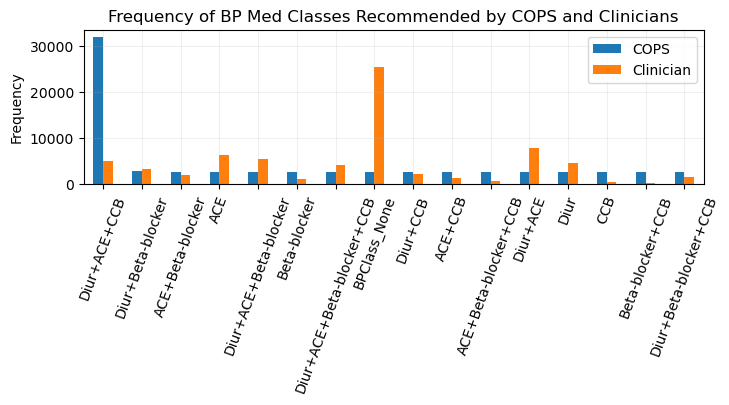


---bg---
                            COPS  Clinician
Bingu+Meglit               18808        950
Bingu+Sulfon                3611      10268
Sulfon                      3568       2266
Bingu+Thiaz+Meglit          3535       2584
BGClass_None                3515      17208
Thiaz+Meglit                3507        373
Meglit                      3503        425
Thiaz+Sulfon                3500       2375
Bingu+Thiaz+Sulfon+Meglit   3495       1837
Sulfon+Meglit               3490        148
Thiaz+Sulfon+Meglit         3485        358
Thiaz                       3473       2691
Bingu+Thiaz                 3452       7133
Bingu+Thiaz+Sulfon          3423      13770
Bingu                       3422       8130
Bingu+Sulfon+Meglit         3393        664


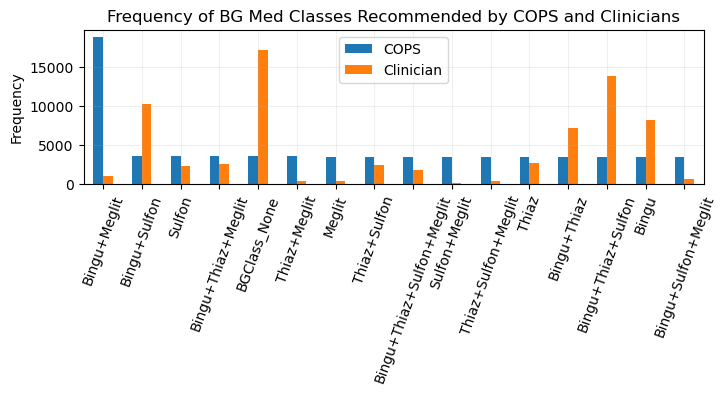


---bpbg---
                                           COPS  Clinician
Diur+ACE+CCB+Bingu+Meglit                 32617       76.0
ACE+CCB+Sulfon                              189       48.0
ACE+Beta-blocker+CCB+Sulfon                 187       40.0
Beta-blocker+Bingu+Thiaz+Sulfon             174      168.0
Diur+ACE+Beta-blocker+Sulfon+Meglit         174        9.0
Diur+Beta-blocker+Thiaz+Meglit              174       11.0
CCB+Bingu+Sulfon+Meglit                     174        2.0
ACE+CCB+Bingu+Thiaz+Sulfon+Meglit           173       26.0
Diur+ACE+Bingu+Sulfon                       173     1500.0
ACE+Beta-blocker+CCB+Bingu+Sulfon+Meglit    172        2.0
Diur+Beta-blocker+Bingu+Meglit              172       56.0
Beta-blocker+Thiaz+Sulfon+Meglit            172        0.0
Beta-blocker+CCB+Thiaz+Meglit               171        0.0
ACE+Beta-blocker+Bingu+Sulfon               171      384.0
Diur+ACE+CCB+Thiaz+Sulfon                   170      174.0
Diur+ACE+Bingu+Thiaz                        

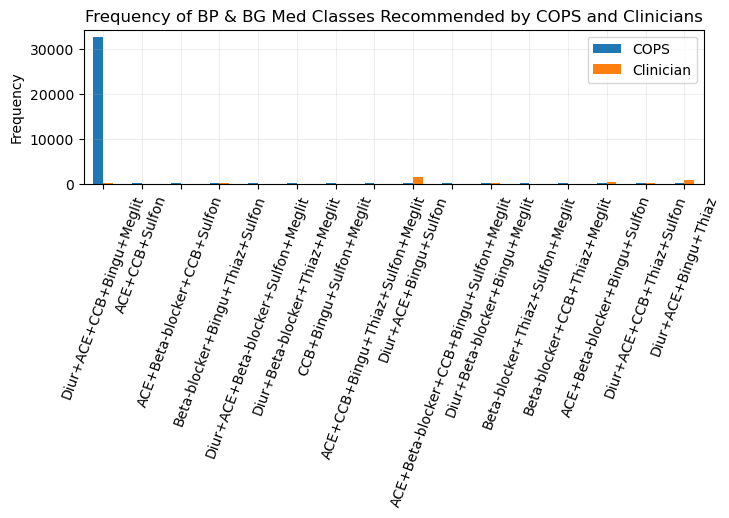

In [68]:
# use bar chart to show the frequency of med_list Column for COPS and Clinicians
import matplotlib.pyplot as plt
import seaborn as sns

def plot_med_list(df, flag):
    
    print()
    print('---{}---'.format(flag))

    # get the frequency count of each unique value in med_list Column in bp_df
    med_COPS = df['med_list'].value_counts()
    med_CLN = df['med_list_cln'].value_counts()

    # merge the two series into a dataframe
    med_df = pd.concat([med_COPS, med_CLN], axis=1)
    med_df.columns = ['COPS', 'Clinician']

    # fill the NaN with 0
    med_df = med_df.fillna(0)
    # print(med_df)
    print(med_df.head(16))    

    # plot the bar chart, one bar for COPS, one bar for Clinician, x-axis is the index, y-axis is the frequency
    if flag == 'bpbg':
        # plot only the top 16 med classes
        med_df = med_df.head(16)
        med_df.plot.bar(figsize=(8,2))
    else:
        med_df.plot.bar(figsize=(8,2))

    if flag == 'bp':
        plt.title('Frequency of BP Med Classes Recommended by COPS and Clinicians')
    if flag == 'bg':
        plt.title('Frequency of BG Med Classes Recommended by COPS and Clinicians')
    if flag == 'bpbg':
        plt.title('Frequency of BP & BG Med Classes Recommended by COPS and Clinicians')

    # plt.xlabel('med_list')
    # rotate x-axis label
    plt.xticks(rotation=70)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.2)
    # plt.show()

    # save the plot to pdf and png
    plt.savefig('plots/MedClass_combo_{}.pdf'.format(flag), bbox_inches='tight')
    plt.savefig('plots/MedClass_combo_{}.png'.format(flag), bbox_inches='tight', dpi=300)

    plt.show()


plot_med_list(bp_df, 'bp')
plot_med_list(bg_df, 'bg')
plot_med_list(bpbg_df, 'bpbg')

## Fig 1 2 3 - Med Class Frequency plot


---bp---
med_cops:  {'Diur': 50181, 'ACE': 50297, 'CCB': 49979, 'Beta-blocker': 21038, 'BPClass_None': 2628}
med_cln:  {'ACE': 32652, 'Diur': 33817, 'CCB': 15549, 'BPClass_None': 25387, 'Beta-blocker': 18277}
               COPS  Clinician
Diur          50181      33817
ACE           50297      32652
CCB           49979      15549
Beta-blocker  21038      18277
BPClass_None   2628      25387


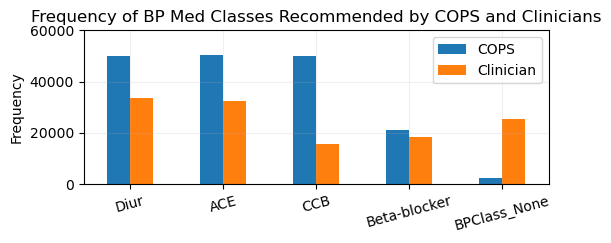


---bg---
med_cops:  {'Bingu': 43139, 'Meglit': 43216, 'Thiaz': 27870, 'Sulfon': 27965, 'BGClass_None': 3515}
med_cln:  {'BGClass_None': 17208, 'Bingu': 45336, 'Thiaz': 31121, 'Sulfon': 31686, 'Meglit': 7339}
               COPS  Clinician
Bingu         43139      45336
Meglit        43216       7339
Thiaz         27870      31121
Sulfon        27965      31686
BGClass_None   3515      17208


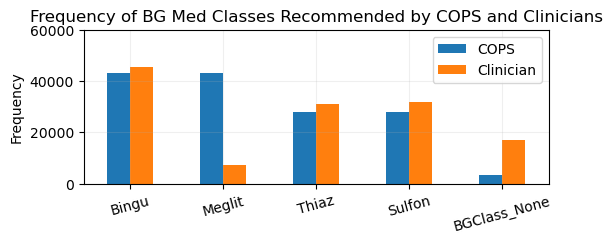


---bpbg---
med_cops:  {'Diur': 51802, 'ACE': 51889, 'CCB': 51664, 'Bingu': 51775, 'Meglit': 51687, 'Beta-blocker': 19435, 'Sulfon': 19595, 'Thiaz': 19452, 'BPBGClass_None': 156}
med_cln:  {'ACE': 32194, 'Diur': 33856, 'CCB': 15563, 'BPBGClass_None': 7262, 'Bingu': 44445, 'Sulfon': 31266, 'Thiaz': 31043, 'Beta-blocker': 17872, 'Meglit': 7217}
                 COPS  Clinician
Diur            51802      33856
ACE             51889      32194
CCB             51664      15563
Bingu           51775      44445
Meglit          51687       7217
Beta-blocker    19435      17872
Sulfon          19595      31266
Thiaz           19452      31043
BPBGClass_None    156       7262


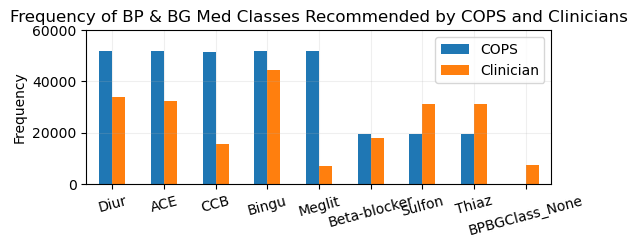

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_med_list(df, flag):
    
    print()
    print('---{}---'.format(flag))

    med_cops = dict()
    med_cln = dict()

    # loop through each row in df
    for i in range(df.shape[0]):
        row = df.iloc[i]
        m_cops = row['med_list'].split('+')
        m_cln = row['med_list_cln'].split('+')

        for m in m_cops:
            if m in med_cops:
                med_cops[m] += 1
            else:
                med_cops[m] = 1
        
        for m in m_cln:
            if m in med_cln:
                med_cln[m] += 1
            else:
                med_cln[m] = 1
    
    print('med_cops: ', med_cops)
    print('med_cln: ', med_cln)
    
    # build a dataframe from med_cops and med_cln
    med_df = pd.DataFrame([med_cops, med_cln])
    med_df = med_df.fillna(0)
    med_df = med_df.T
    med_df.columns = ['COPS', 'Clinician']
    print(med_df)

    # plot the bar chart, one bar for COPS, one bar for Clinician, x-axis is the index, y-axis is the frequency
    med_df.plot.bar(figsize=(6,2))
    if flag == 'bp':
        plt.title('Frequency of BP Med Classes Recommended by COPS and Clinicians')
    if flag == 'bg':
        plt.title('Frequency of BG Med Classes Recommended by COPS and Clinicians')
    if flag == 'bpbg':
        plt.title('Frequency of BP & BG Med Classes Recommended by COPS and Clinicians')

    plt.xticks(rotation=15)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.2)
    #  set ylimit
    plt.ylim(0, 60000)
    # plt.show()

    # save the plot to pdf and png
    plt.savefig('plots/MedClass_{}.pdf'.format(flag), bbox_inches='tight')
    plt.savefig('plots/MedClass_{}.png'.format(flag), bbox_inches='tight', dpi=300)
    plt.show()
    

plot_med_list(bp_df, 'bp')
plot_med_list(bg_df, 'bg')
plot_med_list(bpbg_df, 'bpbg')

## Fig 1 2 3 - Success Rate

CVD Success Rate - compare with prev visit

In [70]:
# get the success rate of CVDRisk reduction 

from tqdm import tqdm

def get_cvd_success_rate(df, col_name):

    success_rate = []
    total_len = 0
    total_suc_ct = 0

    # loop through each patient in the df
    for i in tqdm(range(100001, 110252)):
        df_patient = df[df['MaskId'] == i]

        if len(df_patient) == 0:
            continue
        
        total_len += len(df_patient)
        su_ct = 0
        # loop through each visit of the patient, starting from the second visit
        for j in range(1, len(df_patient)):
            row = df_patient.iloc[j]
            prev_cvd = df_patient.iloc[j-1][col_name]
            current_cvd = row[col_name]
            if current_cvd < prev_cvd:
                su_ct += 1
        
        success_rate.append(su_ct / (len(df_patient) - 1))
        total_suc_ct += su_ct
    
    total_success_rate = total_suc_ct / total_len
    
    return total_success_rate, success_rate

cops_bp_total_success_rate, cops_bp_cvd_suc_rate = get_cvd_success_rate(bp_df, 'cvdrisk_fb')
cln_bp_total_success_rate, cln_bp_cvd_suc_rate = get_cvd_success_rate(bp_df, 'cvdrisk_fb_cln')
cops_bg_total_success_rate, cops_bg_cvd_suc_rate = get_cvd_success_rate(bg_df, 'cvdrisk_fb')
cln_bg_total_success_rate, cln_bg_cvd_suc_rate = get_cvd_success_rate(bg_df, 'cvdrisk_fb_cln')
cops_bpbg_total_success_rate, cops_bpbg_cvd_suc_rate = get_cvd_success_rate(bpbg_df, 'cvdrisk_fb')
cln_bpbg_total_success_rate, cln_bpbg_cvd_suc_rate = get_cvd_success_rate(bpbg_df, 'cvdrisk_fb_cln')

  0%|          | 0/10251 [00:00<?, ?it/s]

100%|██████████| 10251/10251 [00:18<00:00, 568.24it/s]


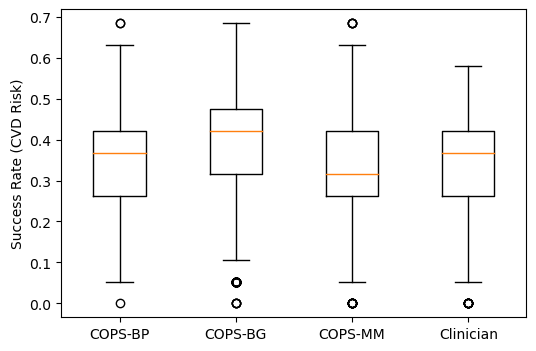

In [71]:
# plot the box plot of success rate

import matplotlib.pyplot as plt

# Combine data into a list
data = [cops_bp_cvd_suc_rate, 
        # cln_bp_cvd_suc_rate, 
        cops_bg_cvd_suc_rate, 
        # cln_bg_cvd_suc_rate,
        cops_bpbg_cvd_suc_rate, 
        cln_bpbg_cvd_suc_rate
        ]

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
plt.boxplot(data)

# Add labels to x-axis tick marks
plt.xticks([1, 2, 3, 4, 
                        # 5, 
                        # 6
                        ], 
                        ['COPS-BP', 
                        # 'CLN-BP',
                        'COPS-BG', 
                        # 'CLN-BG',
                        'COPS-MM', 
                        'Clinician'
                        ])
plt.ylabel('Success Rate (CVD Risk)')
# plt.grid()

# save the plot to pdf and png
plt.savefig('plots/CVDRisk_success_rate.pdf', bbox_inches='tight')
plt.savefig('plots/CVDRisk_success_rate.png', bbox_inches='tight', dpi=300)

plt.show()

#### (last visit -initial visit)

CVD Success Rate 2 - compare with baseline 

In [72]:
# get the success rate of CVDRisk reduction, compare each visit's cvdrisk with baseline cvdrisk, instead of previous visit's cvdrisk 

from tqdm import tqdm

def get_cvd_success_rate_2(df, col_name):

    success_rate = []
    total_len = 0
    total_suc_ct = 0

    # loop through each patient in the df
    for i in tqdm(range(100001, 110252)):
        df_patient = df[df['MaskId'] == i]

        if len(df_patient) == 0:
            continue

        base_cvd = df_patient.iloc[0][col_name]
        final_cvd = df_patient.iloc[-1][col_name]
        cvd_reduction = base_cvd - final_cvd

        # su_ct = abs(cvd_reduction) # def 4
        su_ct = abs(cvd_reduction)/base_cvd * 100# def 3
        success_rate.append(su_ct)

        # if cvd_reduction > 0: # actually reduced
        #     # su_ct = abs(cvd_reduction) # def 1
        #     su_ct = abs(cvd_reduction)/base_cvd * 100 # def 2

        #     success_rate.append(su_ct)
    
    total_success_rate = sum(success_rate)/len(success_rate)

    print('total success rate: ', round(total_success_rate,2))
    print('len of success rate: ', len(success_rate))
    
    return total_success_rate, success_rate

cops_bp_total_success_rate_2, cops_bp_cvd_suc_rate_2 = get_cvd_success_rate_2(bp_df, 'cvdrisk_fb')
# cln_bp_total_success_rate_2, cln_bp_cvd_suc_rate_2 = get_cvd_success_rate_2(bp_df, 'cvdrisk_fb_cln')
cops_bg_total_success_rate_2, cops_bg_cvd_suc_rate_2 = get_cvd_success_rate_2(bg_df, 'cvdrisk_fb')
# cln_bg_total_success_rate_2, cln_bg_cvd_suc_rate_2 = get_cvd_success_rate_2(bg_df, 'cvdrisk_fb_cln')
cops_bpbg_total_success_rate_2, cops_bpbg_cvd_suc_rate_2 = get_cvd_success_rate_2(bpbg_df, 'cvdrisk_fb')
cln_bpbg_total_success_rate_2, cln_bpbg_cvd_suc_rate_2 = get_cvd_success_rate_2(bpbg_df, 'cvdrisk_fb_cln')


100%|██████████| 10251/10251 [00:04<00:00, 2432.08it/s]


total success rate:  18.6
len of success rate:  3559


100%|██████████| 10251/10251 [00:04<00:00, 2463.55it/s]


total success rate:  4.02
len of success rate:  3559


100%|██████████| 10251/10251 [00:03<00:00, 2639.31it/s]


total success rate:  17.47
len of success rate:  3559


100%|██████████| 10251/10251 [00:03<00:00, 2720.71it/s]

total success rate:  14.99
len of success rate:  3559


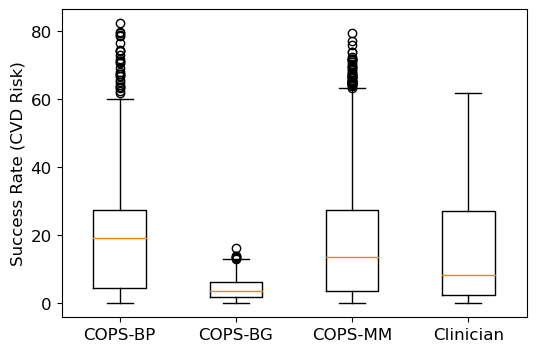

In [73]:
# plot the box plot of success rate

import matplotlib.pyplot as plt

# Combine data into a list
data = [cops_bp_cvd_suc_rate_2, 
        # cln_bp_cvd_suc_rate_2, 
        cops_bg_cvd_suc_rate_2, 
        # cln_bg_cvd_suc_rate_2,
        cops_bpbg_cvd_suc_rate_2, 
        cln_bpbg_cvd_suc_rate_2
        ]

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
plt.boxplot(data)

# Add labels to x-axis tick marks
plt.xticks([1, 2, 3, 4, 
                        # 5, 
                        # 6
                        ], [
                                'COPS-BP', 
                                # 'CLN-BP',
                        'COPS-BG',
                        #  'CLN-BG',
                        'COPS-MM', 
                        'Clinician'
                        ], fontsize=12)
plt.ylabel('Success Rate (CVD Risk)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.grid()
plt.show()

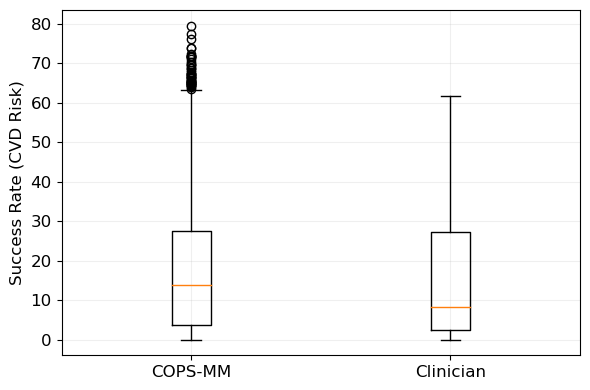

In [74]:
# plot the box plot of success rate

import matplotlib.pyplot as plt

# Combine data into a list
data = [
        # cops_bp_cvd_suc_rate_2, 
        # cln_bp_cvd_suc_rate_2, 
        # cops_bg_cvd_suc_rate_2, 
        # cln_bg_cvd_suc_rate_2,
        cops_bpbg_cvd_suc_rate_2, 
        cln_bpbg_cvd_suc_rate_2
        ]

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
plt.boxplot(data)

# Add labels to x-axis tick marks
plt.xticks([1, 2, ], [
                                # 'COPS-BP', 
                                # 'CLN-BP',
                        # 'COPS-BG',
                        #  'CLN-BG',
                        'COPS-MM', 
                        'Clinician'
                        ], fontsize=12)
plt.ylabel('Success Rate (CVD Risk)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()

plt.savefig('plots/CVDRisk_success_newdef.pdf', bbox_inches='tight')
plt.savefig('plots/CVDRisk_success_newdef.png', bbox_inches='tight', dpi=300)

# plt.grid()
plt.show()



CVD Success Rate 3 - compare last visit with the baseline visit

In [75]:
# get the success rate of CVDRisk reduction, compare each patient's last visit's cvdrisk with baseline cvdrisk 

from tqdm import tqdm

def get_cvd_success_rate_3(df, col_name):

    total_ct = 0
    total_suc_ct = 0

    # loop through each patient in the df
    for i in tqdm(range(100001, 110252)):
        df_patient = df[df['MaskId'] == i]

        if len(df_patient) == 0:
            continue
        
        total_ct += 1
        
        row_last = df_patient.iloc[-1]
        last_cvd = row_last[col_name]
        base_cvd = df_patient.iloc[0][col_name]

        if last_cvd < base_cvd:
            total_suc_ct += 1

    total_success_rate = total_suc_ct / total_ct

    print('total_ct = ', total_ct)
    print('total_suc_ct = ', total_suc_ct)
    
    return total_success_rate

cops_bp_total_success_rate_3 = get_cvd_success_rate_3(bp_df, 'cvdrisk_fb')
cln_bp_total_success_rate_3 = get_cvd_success_rate_3(bp_df, 'cvdrisk_fb_cln')
cops_bg_total_success_rate_3 = get_cvd_success_rate_3(bg_df, 'cvdrisk_fb')
cln_bg_total_success_rate_3 = get_cvd_success_rate_3(bg_df, 'cvdrisk_fb_cln')
cops_bpbg_total_success_rate_3 = get_cvd_success_rate_3(bpbg_df, 'cvdrisk_fb')
cln_bpbg_total_success_rate_3 = get_cvd_success_rate_3(bpbg_df, 'cvdrisk_fb_cln')

100%|██████████| 10251/10251 [00:03<00:00, 2651.46it/s]


total_ct =  3559
total_suc_ct =  2010


100%|██████████| 10251/10251 [00:03<00:00, 2573.17it/s]


total_ct =  3559
total_suc_ct =  2207


100%|██████████| 10251/10251 [00:03<00:00, 2628.63it/s]


total_ct =  3559
total_suc_ct =  1377


100%|██████████| 10251/10251 [00:03<00:00, 2736.09it/s]


total_ct =  3559
total_suc_ct =  2395


100%|██████████| 10251/10251 [00:03<00:00, 2701.18it/s]


total_ct =  3559
total_suc_ct =  2032


100%|██████████| 10251/10251 [00:03<00:00, 2695.77it/s]

total_ct =  3559
total_suc_ct =  2261


In [76]:
print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(cops_bp_total_success_rate_3, cln_bp_total_success_rate_3, 
                                                              cops_bg_total_success_rate_3, cln_bg_total_success_rate_3,
                                                              cops_bpbg_total_success_rate_3, cln_bpbg_total_success_rate_3))

0.56	0.62	0.39	0.67	0.57	0.64


# Distribution plots

/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

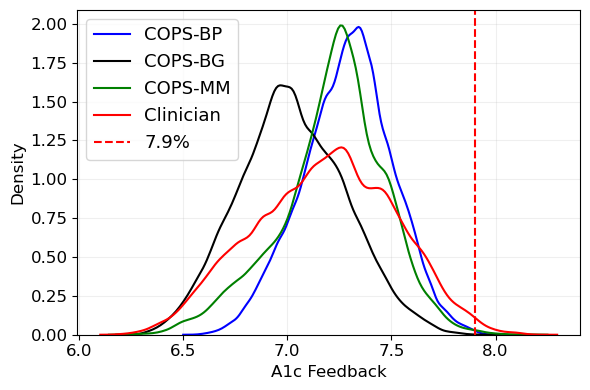

In [77]:
# plot the distribution of bg_df['hba1c_fb'] and bg_df['hba1c_fb_cln']

import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
sns.distplot(bp_df['hba1c_fb'], hist=False, label='COPS-BP', color='blue') 
sns.distplot(bg_df['hba1c_fb'], hist=False, label='COPS-BG', color='black')
sns.distplot(bpbg_df['hba1c_fb'], hist=False, label='COPS-MM', color='green')
sns.distplot(bpbg_df['hba1c_fb_cln'], hist=False, label='Clinician', color='red')

# add a vertical line at x=7.9
plt.axvline(x=7.9, color='r', linestyle='--', label='7.9%')

plt.xlabel('A1c Feedback', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', prop={'size': 13})

# add gridlines with transparency
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("plots/png/a1c_distribution.png", dpi=300, facecolor='w', edgecolor='w')
plt.savefig("plots/pdf/a1c_distribution.pdf", dpi=300, facecolor='w', edgecolor='w') 

/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

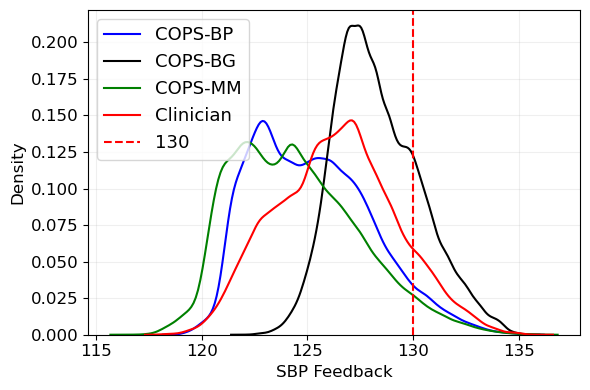

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
sns.distplot(bp_df['sbp_fb'], hist=False, label='COPS-BP', color='blue')
sns.distplot(bg_df['sbp_fb'], hist=False, label='COPS-BG', color='black')
sns.distplot(bpbg_df['sbp_fb'], hist=False, label='COPS-MM', color='green')
sns.distplot(bpbg_df['sbp_fb_cln'], hist=False, label='Clinician', color='red')
# add a vertical line at x=130
plt.axvline(x=130, color='r', linestyle='--', label='130')
plt.xlabel('SBP Feedback', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', prop={'size': 13})
# add gridlines with transparency
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("plots/png/sbp_distribution.png", dpi=300, facecolor='w', edgecolor='w')
plt.savefig("plots/pdf/sbp_distribution.pdf", dpi=300, facecolor='w', edgecolor='w') 

/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/tian/opt/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


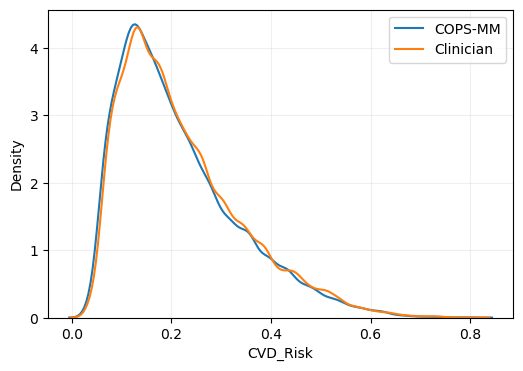

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
# sns.distplot(bp_df['cvdrisk_fb'], hist=False, label='COPS-BP') 
# sns.distplot(bg_df['cvdrisk_fb'], hist=False, label='COPS-BG') 
sns.distplot(bpbg_df['cvdrisk_fb'], hist=False, label='COPS-MM')
sns.distplot(bpbg_df['cvdrisk_fb_cln'], hist=False, label='Clinician')
# add a vertical line at x=130
# plt.axvline(x=130, color='r', linestyle='--', label='130%')
plt.xlabel('CVD_Risk')
plt.legend()
# add gridlines with transparency
plt.grid(alpha=0.2)

In [80]:
# get violation rate of HbA1c

def get_a1c_violation_rate(df, col_name):

    vio_rate = []
    total_len = 0
    total_vio_ct = 0

    # loop through each patient in the df
    # for i in tqdm(range(100001, 110252)):
    for i in tqdm(same_patient):
        df_patient = df[df['MaskId'] == i]

        if len(df_patient) == 0:
            continue
        
        total_len += len(df_patient)
        vio_ct = 0
        # loop through each visit of the patient
        for j in range(len(df_patient)):
            row = df_patient.iloc[j]
            current_a1c = row[col_name]
            # if current_a1c > 7.5 or current_a1c < 6.5:
            # if current_a1c > 7.2 or current_a1c < 6.8:
            # if current_a1c > 7.2 or current_a1c < 7.0:            

            if current_a1c > 7.9:
                vio_ct += 1

        total_vio_ct += vio_ct
        vio_rate.append(vio_ct / (len(df_patient)))
    
    total_vio_rate = total_vio_ct / total_len
    
    return total_vio_rate, vio_rate

cops_bp_total_a1c_vio_rate, cops_bp_a1c_vio_rate = get_a1c_violation_rate(bp_df, 'hba1c_fb')
cln_bp_total_a1c_vio_rate, cln_bp_a1c_vio_rate = get_a1c_violation_rate(bp_df, 'hba1c_fb_cln')
cops_bg_total_a1c_vio_rate, cops_bg_a1c_vio_rate = get_a1c_violation_rate(bg_df, 'hba1c_fb')
cln_bg_total_a1c_vio_rate, cln_bg_a1c_vio_rate = get_a1c_violation_rate(bg_df, 'hba1c_fb_cln')
cops_bpbg_total_a1c_vio_rate, cops_bpbg_a1c_vio_rate = get_a1c_violation_rate(bpbg_df, 'hba1c_fb')
cln_bpbg_total_a1c_vio_rate, cln_bpbg_a1c_vio_rate = get_a1c_violation_rate(bpbg_df, 'hba1c_fb_cln')

100%|██████████| 3559/3559 [00:09<00:00, 365.37it/s]


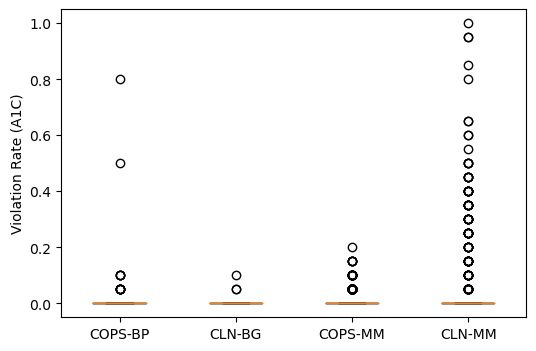

In [81]:
# plot the box plot of violation rate A1C

import matplotlib.pyplot as plt

# Combine data into a list
data = [
        cops_bp_a1c_vio_rate, 
        # cln_bp_a1c_vio_rate,
        cops_bg_a1c_vio_rate, 
        # cln_bg_a1c_vio_rate,
        cops_bpbg_a1c_vio_rate, 
        cln_bpbg_a1c_vio_rate]

# data = [
#         # cops_bp_a1c_vio_rate, cln_bp_a1c_vio_rate,
#         cops_bg_a1c_vio_rate, 
#         cops_bpbg_a1c_vio_rate, cln_bg_a1c_vio_rate,]


# set figure size
plt.figure(figsize=(6, 4))
# Plotting the box plot
plt.boxplot(data)

# Add labels to x-axis tick marks
plt.xticks([1, 2, 3, 4, ], [    'COPS-BP', 'CLN-BG',
                                'COPS-MM', 'CLN-MM'])

# plt.xticks([1, 2, 3,], [    'COPS-BG', 
#                                 'COPS-MM', 'CLN-BG'])

plt.ylabel('Violation Rate (A1C)')
# plt.grid()

# save the plot to pdf and png
plt.savefig('plots/HBA1C_violation_rate.pdf', bbox_inches='tight')
plt.savefig('plots/HBA1C_violation_rate.png', bbox_inches='tight')

plt.show()

Percentiles

In [82]:
# Total CVD risk success rate
print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(cops_bp_total_success_rate_2*100, cln_bp_total_success_rate_2*100, 
                                                              cops_bg_total_success_rate_2*100, cln_bg_total_success_rate_2*100, 
                                                              cops_bpbg_total_success_rate_2*100, cln_bpbg_total_success_rate_2*100))

# CVDRisk percentiles
print("{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}".format(
    np.percentile(cops_bp_cvd_suc_rate_2, 25)*100, np.percentile(cops_bp_cvd_suc_rate_2, 50)*100, np.percentile(cops_bp_cvd_suc_rate_2, 75)*100,
    np.percentile(cln_bp_cvd_suc_rate_2, 25)*100, np.percentile(cln_bp_cvd_suc_rate_2, 50)*100, np.percentile(cln_bp_cvd_suc_rate_2, 75)*100,
    np.percentile(cops_bg_cvd_suc_rate_2, 25)*100, np.percentile(cops_bg_cvd_suc_rate_2, 50)*100, np.percentile(cops_bg_cvd_suc_rate_2, 75)*100,
    np.percentile(cln_bg_cvd_suc_rate_2, 25)*100, np.percentile(cln_bg_cvd_suc_rate_2, 50)*100, np.percentile(cln_bg_cvd_suc_rate_2, 75)*100,
    np.percentile(cops_bpbg_cvd_suc_rate_2, 25)*100, np.percentile(cops_bpbg_cvd_suc_rate_2, 50)*100, np.percentile(cops_bpbg_cvd_suc_rate_2, 75)*100,
    np.percentile(cln_bpbg_cvd_suc_rate_2, 25)*100, np.percentile(cln_bpbg_cvd_suc_rate_2, 50)*100, np.percentile(cln_bpbg_cvd_suc_rate_2, 75)*100))

# Total CVD risk success rate
print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(cops_bp_total_success_rate*100, cln_bp_total_success_rate*100, 
                                                              cops_bg_total_success_rate*100, cln_bg_total_success_rate*100, 
                                                              cops_bpbg_total_success_rate*100, cln_bpbg_total_success_rate*100))

# CVDRisk percentiles
print("{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}".format(
    np.percentile(cops_bp_cvd_suc_rate, 25)*100, np.percentile(cops_bp_cvd_suc_rate, 50)*100, np.percentile(cops_bp_cvd_suc_rate, 75)*100,
    np.percentile(cln_bp_cvd_suc_rate, 25)*100, np.percentile(cln_bp_cvd_suc_rate, 50)*100, np.percentile(cln_bp_cvd_suc_rate, 75)*100,
    np.percentile(cops_bg_cvd_suc_rate, 25)*100, np.percentile(cops_bg_cvd_suc_rate, 50)*100, np.percentile(cops_bg_cvd_suc_rate, 75)*100,
    np.percentile(cln_bg_cvd_suc_rate, 25)*100, np.percentile(cln_bg_cvd_suc_rate, 50)*100, np.percentile(cln_bg_cvd_suc_rate, 75)*100,
    np.percentile(cops_bpbg_cvd_suc_rate, 25)*100, np.percentile(cops_bpbg_cvd_suc_rate, 50)*100, np.percentile(cops_bpbg_cvd_suc_rate, 75)*100,
    np.percentile(cln_bpbg_cvd_suc_rate, 25)*100, np.percentile(cln_bpbg_cvd_suc_rate, 50)*100, np.percentile(cln_bpbg_cvd_suc_rate, 75)*100))

# Total SBP violation rate
print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(cops_bp_total_sbp_vio_rate*100, cln_bp_total_sbp_vio_rate*100,
                                                              cops_bg_total_sbp_vio_rate*100, cln_bg_total_sbp_vio_rate*100,
                                                              cops_bpbg_total_sbp_vio_rate*100, cln_bpbg_total_sbp_vio_rate*100))

# SBP percentiles
print("{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}".format(
    np.percentile(cops_bp_sbp_vio_rate, 25)*100, np.percentile(cops_bp_sbp_vio_rate, 50)*100, np.percentile(cops_bp_sbp_vio_rate, 75)*100,
    np.percentile(cln_bp_sbp_vio_rate, 25)*100, np.percentile(cln_bp_sbp_vio_rate, 50)*100, np.percentile(cln_bp_sbp_vio_rate, 75)*100,
    np.percentile(cops_bg_sbp_vio_rate, 25)*100, np.percentile(cops_bg_sbp_vio_rate, 50)*100, np.percentile(cops_bg_sbp_vio_rate, 75)*100,
    np.percentile(cln_bg_sbp_vio_rate, 25)*100, np.percentile(cln_bg_sbp_vio_rate, 50)*100, np.percentile(cln_bg_sbp_vio_rate, 75)*100,
    np.percentile(cops_bpbg_sbp_vio_rate, 25)*100, np.percentile(cops_bpbg_sbp_vio_rate, 50)*100, np.percentile(cops_bpbg_sbp_vio_rate, 75)*100,
    np.percentile(cln_bpbg_sbp_vio_rate, 25)*100, np.percentile(cln_bpbg_sbp_vio_rate, 50)*100, np.percentile(cln_bpbg_sbp_vio_rate, 75)*100))

# Total HbA1c violation rate
print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(cops_bp_total_a1c_vio_rate*100, cln_bp_total_a1c_vio_rate*100,
                                                              cops_bg_total_a1c_vio_rate*100, cln_bg_total_a1c_vio_rate*100,
                                                              cops_bpbg_total_a1c_vio_rate*100, cln_bpbg_total_a1c_vio_rate*100))

# HbA1c percentiles
print("{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}\t{:.2f}/{:.2f}/{:.2f}".format(
    np.percentile(cops_bp_a1c_vio_rate, 25)*100, np.percentile(cops_bp_a1c_vio_rate, 50)*100, np.percentile(cops_bp_a1c_vio_rate, 75)*100,
    np.percentile(cln_bp_a1c_vio_rate, 25)*100, np.percentile(cln_bp_a1c_vio_rate, 50)*100, np.percentile(cln_bp_a1c_vio_rate, 75)*100,
    np.percentile(cops_bg_a1c_vio_rate, 25)*100, np.percentile(cops_bg_a1c_vio_rate, 50)*100, np.percentile(cops_bg_a1c_vio_rate, 75)*100,
    np.percentile(cln_bg_a1c_vio_rate, 25)*100, np.percentile(cln_bg_a1c_vio_rate, 50)*100, np.percentile(cln_bg_a1c_vio_rate, 75)*100,
    np.percentile(cops_bpbg_a1c_vio_rate, 25)*100, np.percentile(cops_bpbg_a1c_vio_rate, 50)*100, np.percentile(cops_bpbg_a1c_vio_rate, 75)*100,
    np.percentile(cln_bpbg_a1c_vio_rate, 25)*100, np.percentile(cln_bpbg_a1c_vio_rate, 50)*100, np.percentile(cln_bpbg_a1c_vio_rate, 75)*100))

NameError: name 'cln_bp_total_success_rate_2' is not defined

### SBP Success

In [ ]:
# # get the success rate of CVDRisk reduction 
# from tqdm import tqdm

# def get_sbp_success_rate(df):

#     success_rate = []

#     # loop through each patient in the df
#     for i in tqdm(range(100001, 110252)):
#         df_patient = df[df['MaskId'] == i]

#         if len(df_patient) == 0:
#             continue
        
#         su_ct = 0
#         # loop through each visit of the patient
#         for j in range(len(df_patient)):
#             row = df_patient.iloc[j]
#             current_sbp = row['sbp_fb']
#             if current_sbp < 125 and current_sbp >= 110:
#                 su_ct += 1
        
#         success_rate.append(su_ct / (len(df_patient)))
    
#     return success_rate

# bp_sbp_suc_rate = get_sbp_success_rate(bp_df)
# bg_sbp_suc_rate = get_sbp_success_rate(bg_df)
# bpbg_sbp_suc_rate = get_sbp_success_rate(bpbg_df)

# print('bp_sbp_suc_rate: ', bp_sbp_suc_rate)
# print('bg_sbp_suc_rate: ', bg_sbp_suc_rate)
# print('bpbg_sbp_suc_rate: ', bpbg_sbp_suc_rate)

In [ ]:
# # plot the box plot of success rate, one for bp, one for bg, one for bpbg
# import matplotlib.pyplot as plt

# # Combine data into a list
# data = [bp_sbp_suc_rate, bpbg_sbp_suc_rate]

# plt.figure(figsize=(6, 4))
# # Plotting the box plot
# plt.boxplot(data)

# # Add labels to x-axis tick marks
# plt.xticks([1, 2], ['COPS-BP', 'COPS-MM'])
# plt.ylabel('Success Rate (SBP)')
# plt.grid()
# plt.show()

### A1C

In [ ]:
# # get the success rate of CVDRisk reduction 
# from tqdm import tqdm

# def get_a1c_success_rate(df):

#     success_rate = []

#     # loop through each patient in the df
#     for i in tqdm(range(100001, 110252)):
#         df_patient = df[df['MaskId'] == i]

#         if len(df_patient) == 0:
#             continue
        
#         su_ct = 0
#         # loop through each visit of the patient
#         for j in range(len(df_patient)):
#             row = df_patient.iloc[j]
#             current_a1c = row['hba1c_fb']
#             if current_a1c <= 7.9  and current_a1c >= 7.0:
#                 su_ct += 1
        
#         success_rate.append(su_ct / (len(df_patient)))
    
#     return success_rate

# bg_a1c_suc_rate = get_a1c_success_rate(bg_df)
# bpbg_a1c_suc_rate = get_a1c_success_rate(bpbg_df)

# print('bg_a1c_suc_rate: ', bg_a1c_suc_rate)
# print('bpbg_a1c_suc_rate: ', bpbg_a1c_suc_rate)

In [ ]:
# # plot the box plot of success rate, one for bp, one for bg, one for bpbg
# import matplotlib.pyplot as plt

# # Combine data into a list
# data = [bg_a1c_suc_rate, bpbg_a1c_suc_rate]

# plt.figure(figsize=(6, 4))
# # Plotting the box plot
# plt.boxplot(data)

# # Add labels to x-axis tick marks
# plt.xticks([1, 2], ['COPS-BG', 'COPS-MM'])
# plt.ylabel('Success Rate (A1C)')
# plt.grid()
# plt.show()

## Med Frequency over Success and Failure data

In [83]:
# get the success and failed data by Clincian

def get_success_data(df):

    print('df.shape: ', df.shape)
    suc_data = []
    fail_data = []

    # loop through each row in the df
    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        if i%20 == 0: # first visit of each patient
            suc_data.append(row)
            fail_data.append(row)
        else:
            prev_row = df.iloc[i-1]
            if row['cvdrisk_fb_cln'] < prev_row['cvdrisk_fb_cln']:
                suc_data.append(row)
            else:
                fail_data.append(row)
    
    success_df = pd.DataFrame(suc_data)
    print('success_df.shape: ', success_df.shape)

    fail_df = pd.DataFrame(fail_data)
    print('fail_df.shape: ', fail_df.shape)

    return success_df, fail_df


bp_df_suc, bp_df_fail = get_success_data(bp_df)
bg_df_suc, bg_df_fail = get_success_data(bg_df)
bpbg_df_suc, bpbg_df_fail = get_success_data(bpbg_df)

df.shape:  (71180, 23)


100%|██████████| 71180/71180 [00:16<00:00, 4334.76it/s]


success_df.shape:  (23115, 23)
fail_df.shape:  (51624, 23)
df.shape:  (71180, 23)


100%|██████████| 71180/71180 [00:16<00:00, 4215.93it/s]


success_df.shape:  (19884, 23)
fail_df.shape:  (54855, 23)
df.shape:  (71180, 23)


100%|██████████| 71180/71180 [00:16<00:00, 4321.10it/s]


success_df.shape:  (26689, 23)
fail_df.shape:  (48050, 23)



---BP---
med_cops:  {'Diur': 16861, 'ACE': 16998, 'CCB': 16938, 'Beta-blocker': 6196, 'BPClass_None': 732}
med_cln:  {'ACE': 14445, 'Diur': 14397, 'CCB': 6857, 'BPClass_None': 3993, 'Beta-blocker': 6467}


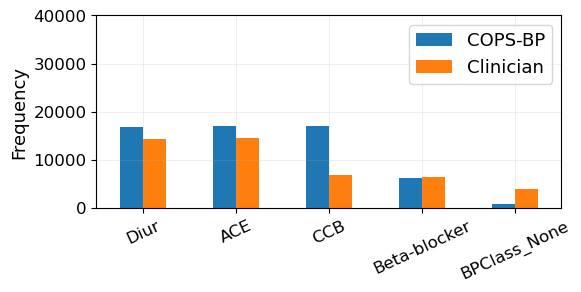


---BP---
med_cops:  {'Diur': 36879, 'ACE': 36858, 'CCB': 36600, 'Beta-blocker': 14842, 'BPClass_None': 1896}
med_cln:  {'ACE': 20645, 'Diur': 21345, 'CCB': 9509, 'Beta-blocker': 12800, 'BPClass_None': 21722}


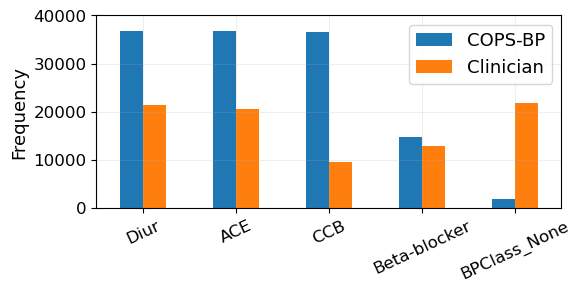

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_med_list_2(df, flag, dataset):
    
    print()
    print('---{}---'.format(flag))

    med_cops = dict()
    med_cln = dict()

    # loop through each row in df
    for i in range(df.shape[0]):
        row = df.iloc[i]
        m_cops = row['med_list'].split('+')
        m_cln = row['med_list_cln'].split('+')

        for m in m_cops:
            if m in med_cops:
                med_cops[m] += 1
            else:
                med_cops[m] = 1
        
        for m in m_cln:
            if m in med_cln:
                med_cln[m] += 1
            else:
                med_cln[m] = 1
    
    print('med_cops: ', med_cops)
    print('med_cln: ', med_cln)
    
    # build a dataframe from med_cops and med_cln
    med_df = pd.DataFrame([med_cops, med_cln])
    med_df = med_df.fillna(0)
    med_df = med_df.T
    med_df.columns = ['COPS-{}'.format(flag), 'Clinician']
    # print(med_df)

    med_df.plot.bar(figsize=(6,2.5))
    plt.legend(loc='upper right', prop={'size': 13})
    plt.grid(alpha=0.2)
    # set y-axis range
    plt.ylim(0, 40000)

    # plot the bar chart, one bar for COPS, one bar for CLN, x-axis is the index, y-axis is the frequency
    # if flag == 'BP':
    #     plt.title('Frequency of BP Med Classes Recommended by COPS-{} and Clinicians - {}'.format(flag, dataset))
    # if flag == 'BG':
    #     plt.title('Frequency of BG Med Classes Recommended by COPS-{} and Clinicians - {}'.format(flag, dataset))
    # if flag == 'MM':
    #     plt.title('Frequency of BP & BG Med Classes Recommended by COPS-{} and Clinicians - {}'.format(flag, dataset))         

    plt.xticks(rotation=25, fontsize=12)
    plt.yticks(fontsize=12)

    plt.ylabel('Frequency', fontsize=13)

    # save the plot to pdf and png
    plt.savefig('plots/MedClasses_{}_{}.pdf'.format(flag, dataset), bbox_inches='tight')
    plt.savefig('plots/MedClasses_{}_{}.png'.format(flag, dataset), bbox_inches='tight', dpi=300)   

    plt.show()
    

plot_med_list_2(bp_df_suc, 'BP', 'Success')
plot_med_list_2(bp_df_fail, 'BP', 'Fail')



---BG---
med_cops:  {'Bingu': 13095, 'Meglit': 13125, 'Thiaz': 6786, 'Sulfon': 6769, 'BGClass_None': 853}
med_cln:  {'BGClass_None': 4441, 'Bingu': 13930, 'Thiaz': 6420, 'Sulfon': 7698, 'Meglit': 2381}


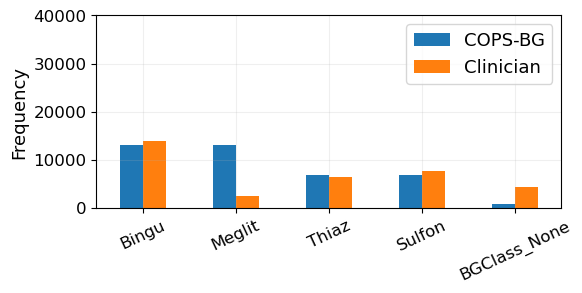


---BG---
med_cops:  {'Bingu': 33603, 'Meglit': 33650, 'Thiaz': 21084, 'Sulfon': 21196, 'BGClass_None': 2662}
med_cln:  {'BGClass_None': 13103, 'Bingu': 34063, 'Thiaz': 26116, 'Sulfon': 25983, 'Meglit': 5069}


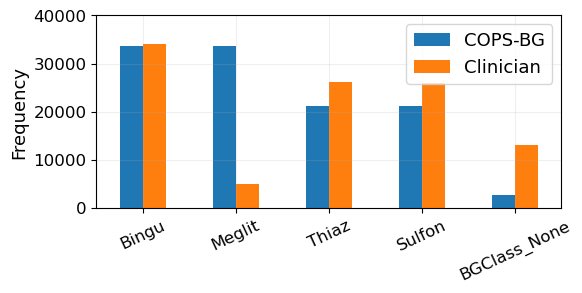

In [85]:
plot_med_list_2(bg_df_suc, 'BG', 'Success')
plot_med_list_2(bg_df_fail, 'BG', 'Fail')


---MM---
med_cops:  {'Diur': 20042, 'ACE': 20075, 'CCB': 19893, 'Bingu': 19940, 'Meglit': 19934, 'Beta-blocker': 6796, 'Sulfon': 6828, 'Thiaz': 6850, 'BPBGClass_None': 48}
med_cln:  {'ACE': 16241, 'Diur': 16760, 'CCB': 7653, 'BPBGClass_None': 1846, 'Bingu': 16917, 'Thiaz': 10299, 'Sulfon': 10629, 'Beta-blocker': 8061, 'Meglit': 3025}


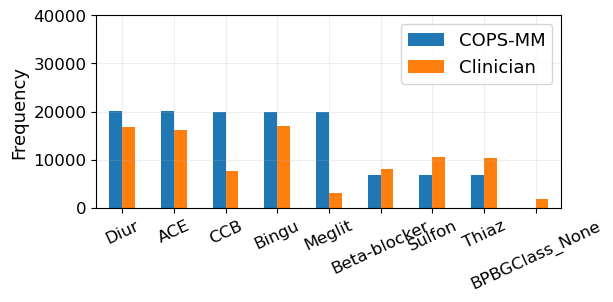


---MM---
med_cops:  {'Diur': 35319, 'ACE': 35373, 'CCB': 35330, 'Bingu': 35394, 'Meglit': 35312, 'Beta-blocker': 12639, 'Thiaz': 12602, 'Sulfon': 12767, 'BPBGClass_None': 108}
med_cln:  {'ACE': 18391, 'Diur': 19021, 'BPBGClass_None': 5440, 'CCB': 8727, 'Bingu': 30185, 'Sulfon': 22632, 'Thiaz': 22159, 'Beta-blocker': 10801, 'Meglit': 4303}


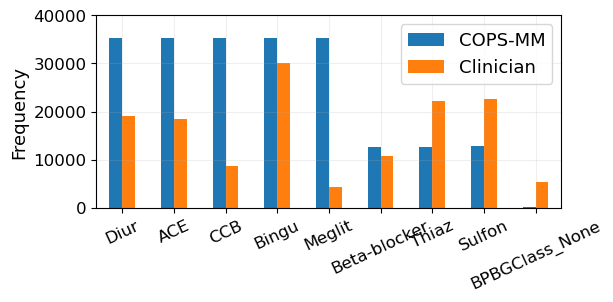

In [86]:
plot_med_list_2(bpbg_df_suc, 'MM', 'Success')
plot_med_list_2(bpbg_df_fail, 'MM', 'Fail')